# Import

In [1]:
import numpy as np
from scipy.linalg import toeplitz
from sys import getsizeof
from timeit import default_timer as time
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from numpy.linalg import inv
import functions_eq_mag as fc
import functions_fatiando as ft
import fourier_continuation as fc_c
import pickle as pickle
%matplotlib inline

# Observation and Equivalent layer grids

In [2]:
# Create a regular grid at 0m height
area = [-5000., 5000., -4000., 4000.]
shape = (50, 50)
N = shape[0]*shape[1]
xi, yi, zi = ft.gridder_regular(area, shape, z=-900.)
#x_perc = (xi[shape[1]]-xi[0])*0.10
#y_perc = (yi[1]-yi[0])*0.10
#z_perc = (-zi[0])*0.10
#np.random.seed(10)
#noise_x = np.random.normal(0, x_perc, len(xi))
#noise_y = np.random.normal(0, y_perc, len(xi))
#noise_z = np.random.normal(0, z_perc, len(zi))
#xi = xi + noise_x
#yi = yi + noise_y
#zi = zi + noise_z

xi_plot, yi_plot, = xi/1000, yi/1000

# Equivalent Layer
areaj = [-5000., 5000., -4000., 4000.]
shapej = (50, 50)
Nj = shapej[0]*shapej[1]
xj, yj, zj = ft.gridder_regular(areaj, shapej, z=50)

## Create the model

In [3]:
# Model
verts1 = [[-3500, -3000], [-2000, -3000], [-2000, 3000], [-3500, 3000]]
#verts2 = [[4000, -3000], [4500, -2500], [0, 3500], [-500, 3000]]
model_prism = [ft.mesher_PolygonalPrism(verts1, 900., 1500., props={'magnetization':[2,2,2]})]

R1 = 1000 #Radius 1
R2 = 750 #Radius 2
xc1, yc1, zc1 = 3000., -2000., 2000. #Center of sphere 1
xc2, yc2, zc2 = 1000., 2500., 1800. #Center of sphere 2
model_sphere = [ft.mesher_Sphere(xc1, yc1, zc1, R1, props={'magnetization':[2,2,2]}),
                ft.mesher_Sphere(xc2, yc2, zc2, R2, props={'magnetization':[2,2,2]})]

print (ft.utils_vec2ang([2,2,2]))

[3.4641016151377544, 35.264389682754654, 45.0]


In [4]:
# Magnetic Configuration, inc 35.26, dec 45
inc0 = np.deg2rad(20)
dec0 = np.deg2rad(35)
inc = np.deg2rad(20)
dec = np.deg2rad(35)

F = np.array([np.cos(inc0)*np.cos(dec0), np.cos(inc0)*np.sin(dec0), np.sin(inc0)])
h = np.array([np.cos(inc)*np.cos(dec), np.cos(inc)*np.sin(dec), np.sin(inc)])

In [5]:
data = []
delta_g = []
tf_prism = ft.polyprism_tf(xi, yi, zi, model_prism, np.rad2deg(inc0), np.rad2deg(dec0))
tf_sphere = ft.sphere_tf(xi, yi, zi, model_sphere, np.rad2deg(inc0), np.rad2deg(dec0))
dobs_0 = tf_prism + tf_sphere
data.append(dobs_0)
noise = np.linspace(1,10,20)/100
seed = np.linspace(1,20,20, dtype='int64')
norm_g = np.linalg.norm(dobs_0)
for i in range(len(noise)):
    dobs = ft.utils_contaminate(dobs_0, noise[i], seed=seed[i], percent=True)
    norm_gl = np.linalg.norm(dobs-dobs_0)/norm_g
    data.append(dobs)
    delta_g.append(norm_gl)

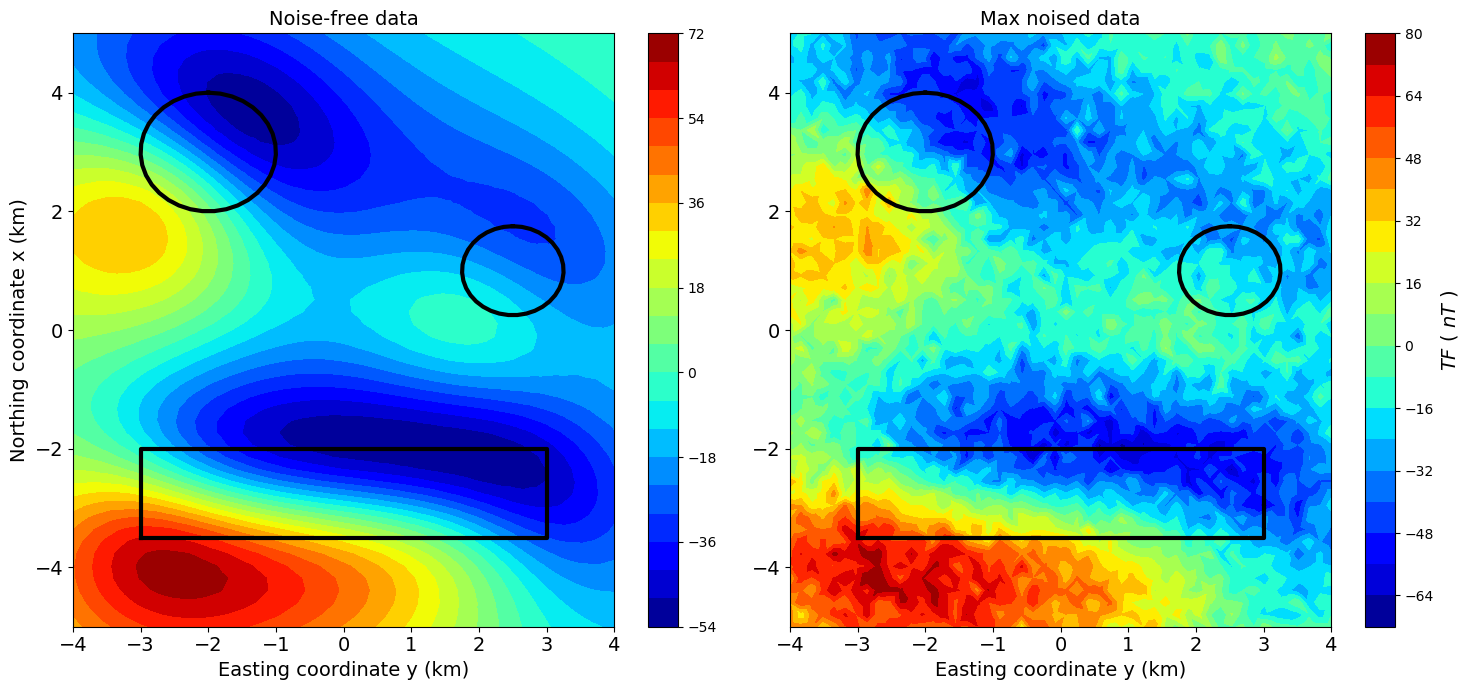

In [6]:
#Projection_model 
phi = np.linspace(0, 2.*np.pi, 36)  #36 points
x1 = xc1/1000 + (R1/1000)*np.cos(phi)
y1 = yc1/1000 + (R1/1000)*np.sin(phi)
x2 = xc2/1000 + (R2/1000)*np.cos(phi)
y2 = yc2/1000 + (R2/1000)*np.sin(phi)

x_p = [-3.5, -2., -2., -3.5, -3.5]
y_p = [-3., -3., 3., 3., -3.]

fig = plt.figure(figsize=(15,7))
fig.patch.set_facecolor('xkcd:white')

plt.subplot(121)
plt.title('Noise-free data', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,data[0],22,cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(122)
plt.title('Max noised data', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,data[-1],22,cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.tight_layout()
#plt.savefig('../../manuscript/Fig/synthetic_mag.png', dpi=300)

# Classic Forward Problem Construction - MAG

In [7]:
# Calculo da matriz de sensibilidade
delta_p_classical = []
p_list = []
p_0, tf_c = fc.classic_mag(xi,yi,zi,zj,F,h,N,data[0])
norm_p_0 = np.linalg.norm(p_0)
for i in range(len(data)-1):
    p, tf_c = fc.classic_mag(xi,yi,zi,zj,F,h,N,data[i+1])
    norm_pl = np.linalg.norm(p-p_0)/norm_p_0
    p_list.append(p)
    delta_p_classical.append(norm_pl)

### BCCB  matrix-vector product with Linear CGLS implementation

In [8]:
delta_p_BCCB = []
p_bccb_list = []
itmax = 50
p_bccb_0, tf_bccb = fc.cgls_eq_bccb_mag(xi,yi,zi,zj,shape,data[0],F,h,itmax)
norm_p_bccb_0 = np.linalg.norm(p_bccb_0)
for i in range(len(data)-1):
    p_bccb, tf_bccb = fc.cgls_eq_bccb_mag(xi,yi,zi,zj,shape,data[i+1],F,h,itmax)
    norm_p_c = np.linalg.norm(p_bccb-p_bccb_0)/norm_p_bccb_0
    p_bccb_list.append(p_bccb)
    delta_p_BCCB.append(norm_p_c)

## Deconvolution

In [9]:
delta_p_dec = []
rho_c_dec_list = []
rho_c_0_dec, gzp_dec = fc.fast_eq_dec_mag(xi,yi,zi,zj,F,h,N,shape,data[0])
norm_rho_c_0_dec = np.linalg.norm(rho_c_0_dec)
for i in range(len(data)-1):
    rho_c_dec, tf_dec = fc.fast_eq_dec_mag(xi,yi,zi,zj,F,h,N,shape,data[i+1])
    norm_rho_c_dec = np.linalg.norm(rho_c_dec-rho_c_0_dec)/norm_rho_c_0_dec
    rho_c_dec_list.append(rho_c_dec)
    delta_p_dec.append(norm_rho_c_dec)

## Deconvolution wiith Wiener stabilization

In [10]:
# Regularization factor of Wiener deconvolution
a, b, c = -10, -13, -16
mu0 = 10**(a)
mu1 = 10**(b)
mu2 = 10**(c)

delta_p_dec_wiener0 = []
delta_p_dec_wiener1 = []
delta_p_dec_wiener2 = []
rho_c_dec_wiener0_list = []
rho_c_dec_wiener1_list = []
rho_c_dec_wiener2_list = []

rho_c_0_dec_wiener, tf_0_dec_wiener = fc.fast_eq_dec_mag_wiener(xi,yi,zi,zj,F,h,N,shape,data[0],mu0)
norm_rho_c_0_dec_wiener = np.linalg.norm(rho_c_0_dec_wiener)

rho_c_1_dec_wiener, tf_1_dec_wiener = fc.fast_eq_dec_mag_wiener(xi,yi,zi,zj,F,h,N,shape,data[0],mu1)
norm_rho_c_1_dec_wiener = np.linalg.norm(rho_c_1_dec_wiener)

rho_c_2_dec_wiener, tf_2_dec_wiener = fc.fast_eq_dec_mag_wiener(xi,yi,zi,zj,F,h,N,shape,data[0],mu2)
norm_rho_c_2_dec_wiener = np.linalg.norm(rho_c_2_dec_wiener)

for j in range(len(data)-1):
    
    rho_c_dec_wiener0, tf_dec_wiener0 = fc.fast_eq_dec_mag_wiener(xi,yi,zi,zj,F,h,N,shape,data[j+1],mu0)
    norm_rho_c_dec_wiener0 = np.linalg.norm(rho_c_dec_wiener0-rho_c_0_dec_wiener)/norm_rho_c_0_dec_wiener
    rho_c_dec_wiener0_list.append(rho_c_dec_wiener0)
    delta_p_dec_wiener0.append(norm_rho_c_dec_wiener0)
    
    rho_c_dec_wiener1, tf_dec_wiener1 = fc.fast_eq_dec_mag_wiener(xi,yi,zi,zj,F,h,N,shape,data[j+1],mu1)
    norm_rho_c_dec_wiener1 = np.linalg.norm(rho_c_dec_wiener1-rho_c_1_dec_wiener)/norm_rho_c_1_dec_wiener
    rho_c_dec_wiener1_list.append(rho_c_dec_wiener1)
    delta_p_dec_wiener1.append(norm_rho_c_dec_wiener1)
    
    rho_c_dec_wiener2, tf_dec_wiener2 = fc.fast_eq_dec_mag_wiener(xi,yi,zi,zj,F,h,N,shape,data[j+1],mu2)
    norm_rho_c_dec_wiener2 = np.linalg.norm(rho_c_dec_wiener2-rho_c_2_dec_wiener)/norm_rho_c_2_dec_wiener
    rho_c_dec_wiener2_list.append(rho_c_dec_wiener2)
    delta_p_dec_wiener2.append(norm_rho_c_dec_wiener2)

## Figure plots

## Transformations comparison - Upward continuation

In [11]:
z_up = np.ones_like(xi) * - 1400

tf_prism_up = ft.polyprism_tf(xi, yi, z_up, model_prism, np.rad2deg(inc0), np.rad2deg(dec0))
tf_sphere_up = ft.sphere_tf(xi, yi, z_up, model_sphere, np.rad2deg(inc0), np.rad2deg(dec0))
dobs_up = tf_prism_up + tf_sphere_up

In [12]:
A_up = fc.sensibility_matrix(xi,yi,z_up,zj,F,h,N)

tf_c_up = np.dot(A_up,p_list[-1])
tf_bccb_up = np.dot(A_up,p_bccb_list[-1])
tf_dec_up = np.dot(A_up,rho_c_dec_list[-1])
tf_dec_wiener0_up = np.dot(A_up,rho_c_dec_wiener0_list[-1])
tf_dec_wiener1_up = np.dot(A_up,rho_c_dec_wiener1_list[-1])
tf_dec_wiener2_up = np.dot(A_up,rho_c_dec_wiener2_list[-1])

scale_max = np.max(tf_c_up)
scale_min = np.min(tf_c_up)

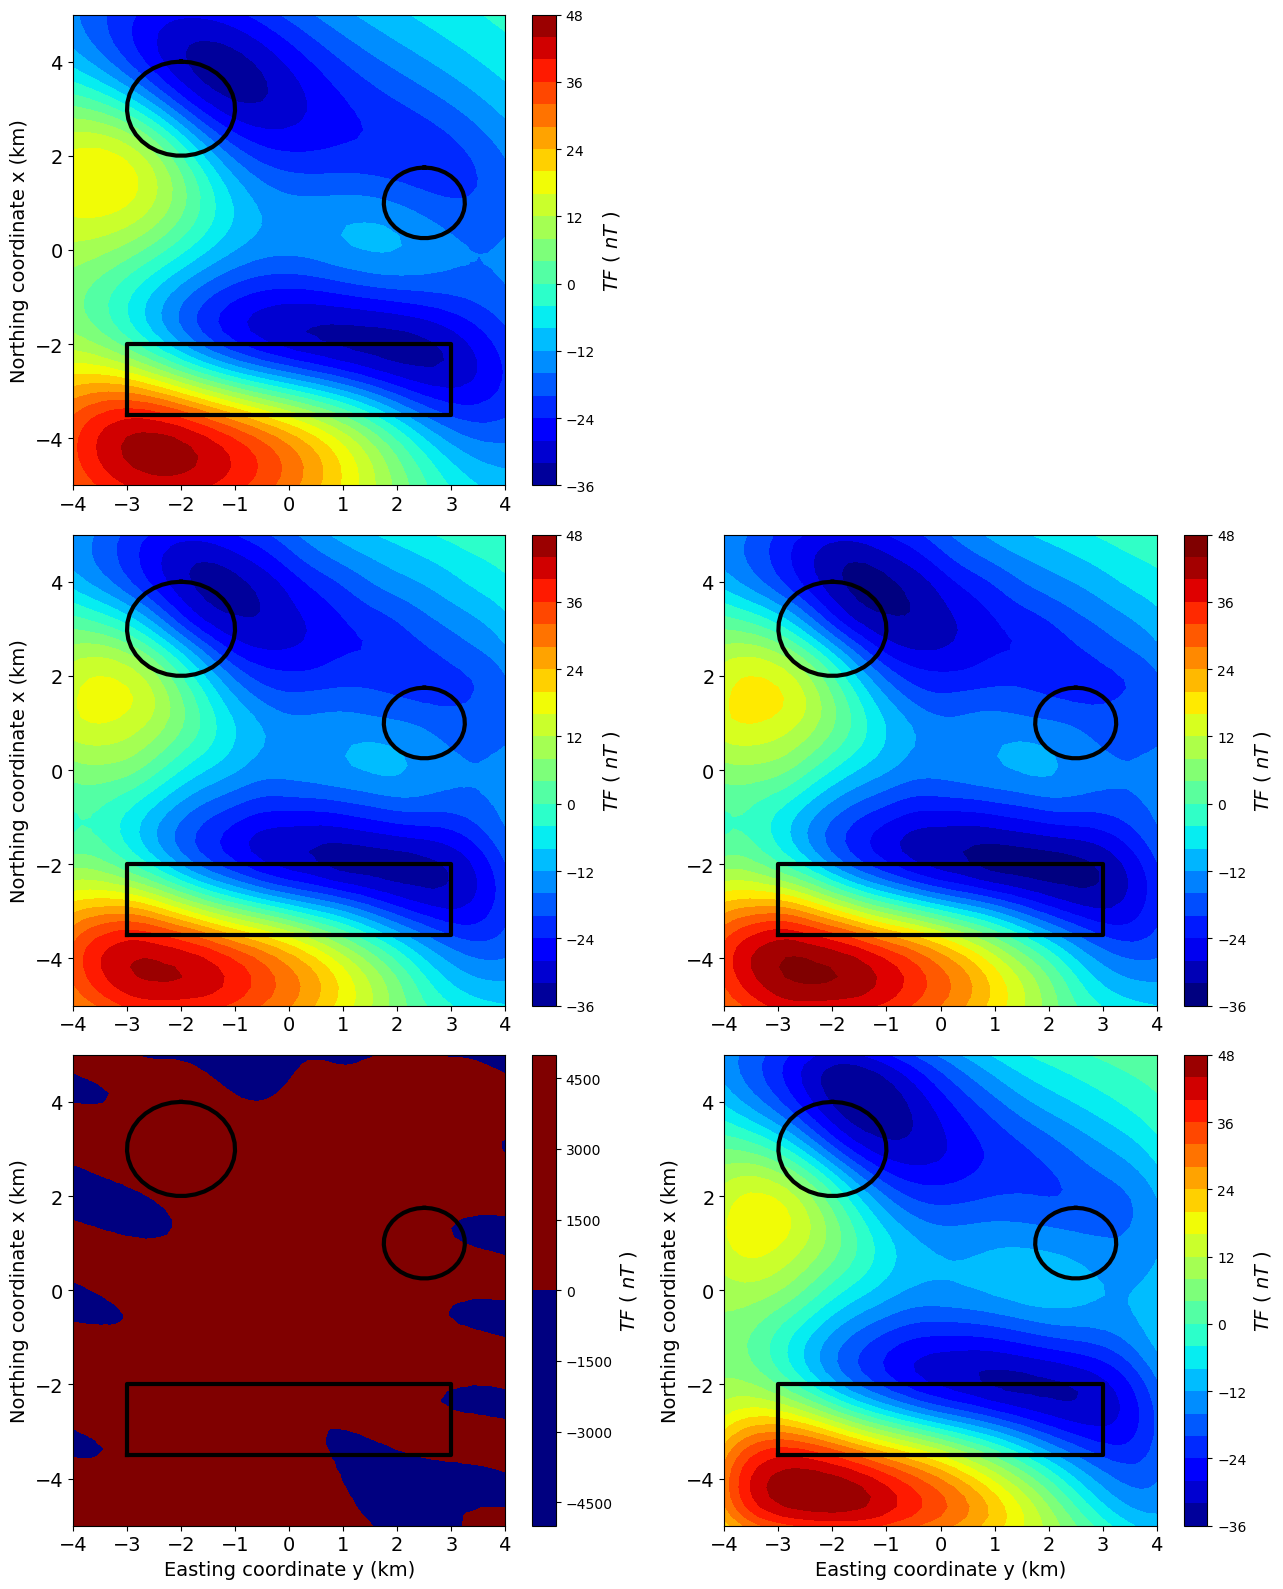

In [13]:
#Projection_model 
phi = np.linspace(0, 2.*np.pi, 36)  #36 points
x1 = xc1/1000 + (R1/1000)*np.cos(phi)
y1 = yc1/1000 + (R1/1000)*np.sin(phi)
x2 = xc2/1000 + (R2/1000)*np.cos(phi)
y2 = yc2/1000 + (R2/1000)*np.sin(phi)

x_p = [-3.5, -2., -2., -3.5, -3.5]
y_p = [-3., -3., 3., 3., -3.]

fig = plt.figure(figsize=(13,16))
fig.patch.set_facecolor('xkcd:white')

plt.subplot(321)
#plt.title('True upward data', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,dobs_up,22,cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(323)
#plt.title('Classical', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,tf_c_up,22,cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(324)
#plt.title('Convolutional', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,tf_bccb_up,22, vmin=scale_min, vmax=scale_max, cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(325)
#plt.title('Deconvolutional', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,tf_dec_up,22, vmin=scale_min, vmax=scale_max, cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)


plt.subplot(326)
#plt.title('Deconvolutional w\ Wiener optimal \u03BC = $10^{-13}$', y=1, x=0.5, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,tf_dec_wiener1_up,22,cmap='jet')
plt.plot(y_p,x_p,color="k", linewidth=3)
#plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y1, x1, color="k", linewidth=3)
plt.plot(y2, x2, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.tight_layout()
plt.savefig('../../manuscript/Fig/mag_upward.png', dpi=300)

In [16]:
print (np.mean(np.abs(dobs_up-tf_c_up)), ('(Classical method)'))
print (np.mean(np.abs(dobs_up-tf_bccb_up)), ('(CG BTTB method)'))
print (np.mean(np.abs(dobs_up-tf_dec_up)), ('(Deconvolutional method)'))
print (np.mean(np.abs(dobs_up-tf_dec_wiener0_up)), ('(Deconvolutional w\ Wiener overshoot \u03BC method)'))
print (np.mean(np.abs(dobs_up-tf_dec_wiener1_up)), ('(Deconvolutional w\ Wiener optimal \u03BC method)'))
print (np.mean(np.abs(dobs_up-tf_dec_wiener2_up)), ('(Deconvolutional w\ Wiener suboptimal \u03BC method)'))
print ()
print (np.std(np.abs(dobs_up-tf_c_up)), ('(Classical method)'))
print (np.std(np.abs(dobs_up-tf_bccb_up)), ('(CG BTTB method)'))
print (np.std(np.abs(dobs_up-tf_dec_up)), ('(Deconvolutional method)'))
print (np.std(np.abs(dobs_up-tf_dec_wiener0_up)), ('(Deconvolutional w\ Wiener overshoot \u03BC method)'))
print (np.std(np.abs(dobs_up-tf_dec_wiener1_up)), ('(Deconvolutional w\ Wiener optimal \u03BC method)'))
print (np.std(np.abs(dobs_up-tf_dec_wiener2_up)), ('(Deconvolutional w\ Wiener suboptimal \u03BC method)'))

0.7785814150218466 (Classical method)
0.7655108796383836 (CG BTTB method)
559.8296747995533 (Deconvolutional method)
16.592332789203407 (Deconvolutional w\ Wiener overshoot μ method)
1.8957320841746346 (Deconvolutional w\ Wiener optimal μ method)
12.826366136984205 (Deconvolutional w\ Wiener suboptimal μ method)

0.7761283931836896 (Classical method)
0.7464135917816536 (CG BTTB method)
683.4916640069628 (Deconvolutional method)
8.520878518238664 (Deconvolutional w\ Wiener overshoot μ method)
1.4699981530742228 (Deconvolutional w\ Wiener optimal μ method)
15.697383395889885 (Deconvolutional w\ Wiener suboptimal μ method)
